In [1]:
# load data and processing
# Aug 8 2021 
# allensdk 1.5.1  pandas 0.25.3

In [1]:
import numpy as np
import scipy as sp
from scipy.linalg import norm
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy.matlib
import pandas as pd

from allensdk.api.queries.ontologies_api import OntologiesApi
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from mcmodels.core import VoxelModelCache

import pickle
import sklearn as sk
# import plotly.express as px

/Users/Allen/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/Allen/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
import plotly.express as px
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [8]:
# load helper functions
from helper import load_hierarchy, plot_connectivity, generate_connectivity, generate_random_connectivity

In [9]:
filepath = './'  # change path accordingly
libfilepath = './lib/'  # change path accordingly

# load the harris hierarchy N =37; 
area_list_hier = ['ACAd', 'ACAv', 'AId', 'AIp', 'AIv', 'AUDd', 'AUDp', 'AUDpo', 'FRP', 'ILA', 'MOp', 'MOs', 'ORBl',
         'ORBm', 'ORBvl', 'PL', 'RSPagl', 'RSPd', 'RSPv', 'SSp-bfd', 'SSp-ll', 'SSp-m', 'SSp-n',
         'SSp-tr', 'SSp-ul', 'SSs', 'TEa', 'VISa', 'VISal', 'VISam', 'VISl', 'VISli', 'VISp',
         'VISpl', 'VISpm', 'VISpor', 'VISrl']  # list of areas in the current model based on published paper.
        # SSp-un and VISC are removed. 

hierfilename = 'mouse_harrishier_extracted_CC_published.csv'

[harrisHierarchy, harrisHierarchy_df] = load_hierarchy(libfilepath, hierfilename, area_list_hier)
harrisHierarchy_df.to_csv('results/dfHarrisHier.csv')

In [10]:
harrisHierarchy_df

,hierarchy index
ACAd,0.940515
ACAv,0.893323
AId,0.598768
AIp,0.301334
AIv,1.000000
AUDd,0.247638
AUDp,0.166607
AUDpo,0.755853
FRP,0.753635
ILA,0.596419


In [11]:
area_list = ['ACAd', 'ACAv', 'AId', 'AIp', 'AIv', 'AUDd', 'AUDp', 'AUDpo', 'AUDv', 'ECT', 'FRP', 'GU', 'ILA', 'MOp', 'MOs', 'ORBl',
         'ORBm', 'ORBvl', 'PERI', 'PL', 'RSPagl', 'RSPd', 'RSPv', 'SSp-bfd', 'SSp-ll', 'SSp-m', 'SSp-n',
         'SSp-tr', 'SSp-ul', 'SSp-un', 'SSs', 'TEa','VISC', 'VISa', 'VISal', 'VISam', 'VISl', 'VISli', 'VISp',
         'VISpl', 'VISpm', 'VISpor', 'VISrl']
n_areas = len(area_list)

In [12]:
# define divisions from Harris et al.
div = {'somatomotor':['SSp-bfd','SSp-tr','SSp-ll','SSp-ul',
                     'SSp-un','SSp-n','SSp-m','SSs','MOp','MOs'],
      'visual':['VISal','VISl','VISp','VISpl',
                'VISli','VISpor','VISrl'],
      'medial':['VISa','VISam','VISpm','RSPagl',
               'RSPd','RSPv'],
      'prefrontal':['FRP','ACAd','ACAv','PL',
                   'ILA','ORBl','ORBm','ORBvl'],
      'lateral':['AId','AIv','AIp','VISC',
                 'GU','TEa','PERI','ECT'],
      'auditory':['AUDd','AUDp','AUDpo','AUDv']}

div_color_list = np.array([[255, 140, 0],
                           [169, 164, 217],
                           [22, 37, 128],
                           [220,20,60],
                           [218,165,32],
                           [91,  0,  105]])/255
# div_color_list = {
#     'somatomotor':[255, 140, 0],
#       'visual':[169, 164, 217],
#       'medial':[22, 37, 128],
#       'prefrontal':[220,20,60],
#       'lateral':[218,165,32],
#       'auditory':[91,  0,  105]}

div_name_list = ['somatomotor',
                 'visual',
                 'medial',
                 'prefrontal',
                 'lateral',
                 'auditory']

In [13]:
def plotHiernotebook(hierarchy_df, dotSize, yaxis, figureSize, fontSize, saveFig, fileName):
        # seaborn.set()
    dfRaw = hierarchy_df.sort_values(hierarchy_df.columns[0])

    fig = plt.figure(figsize = figureSize, dpi=300, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size': fontSize})
    
    xx = np.arange(len(hierarchy_df))
    plt.plot(xx, dfRaw.values, '.-', markersize=dotSize, color='k')
    plt.xticks(xx, dfRaw.index, rotation = 90, fontsize=fontSize*0.6)
    plt.ylabel(yaxis) #r'$e_i/e_1$'
    # regPV = sk.linear_model.LinearRegression()
    # xx2 = xx[np.newaxis].T
    # regPV.fit(xx2, dfRaw.values)
    # print(regPV.coef_, regPV.intercept_)
    # plt.plot(xx, xx * regPV.coef_[0][0] + regPV.intercept_[0], alpha = 0.5)
    ax = plt.gca()
#     [t.set_color('red') for t in ax.xaxis.get_ticklabels()]
    for t in ax.xaxis.get_ticklabels():
        label = t._text
        for i in range(6):
            if label in div[div_name_list[i]]:
                t.set_color(div_color_list[i])
    # plt.grid(alpha = 0.5)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if saveFig:
        plt.savefig('figure/' + fileName, dpi=300, bbox_inches='tight',transparent=True)

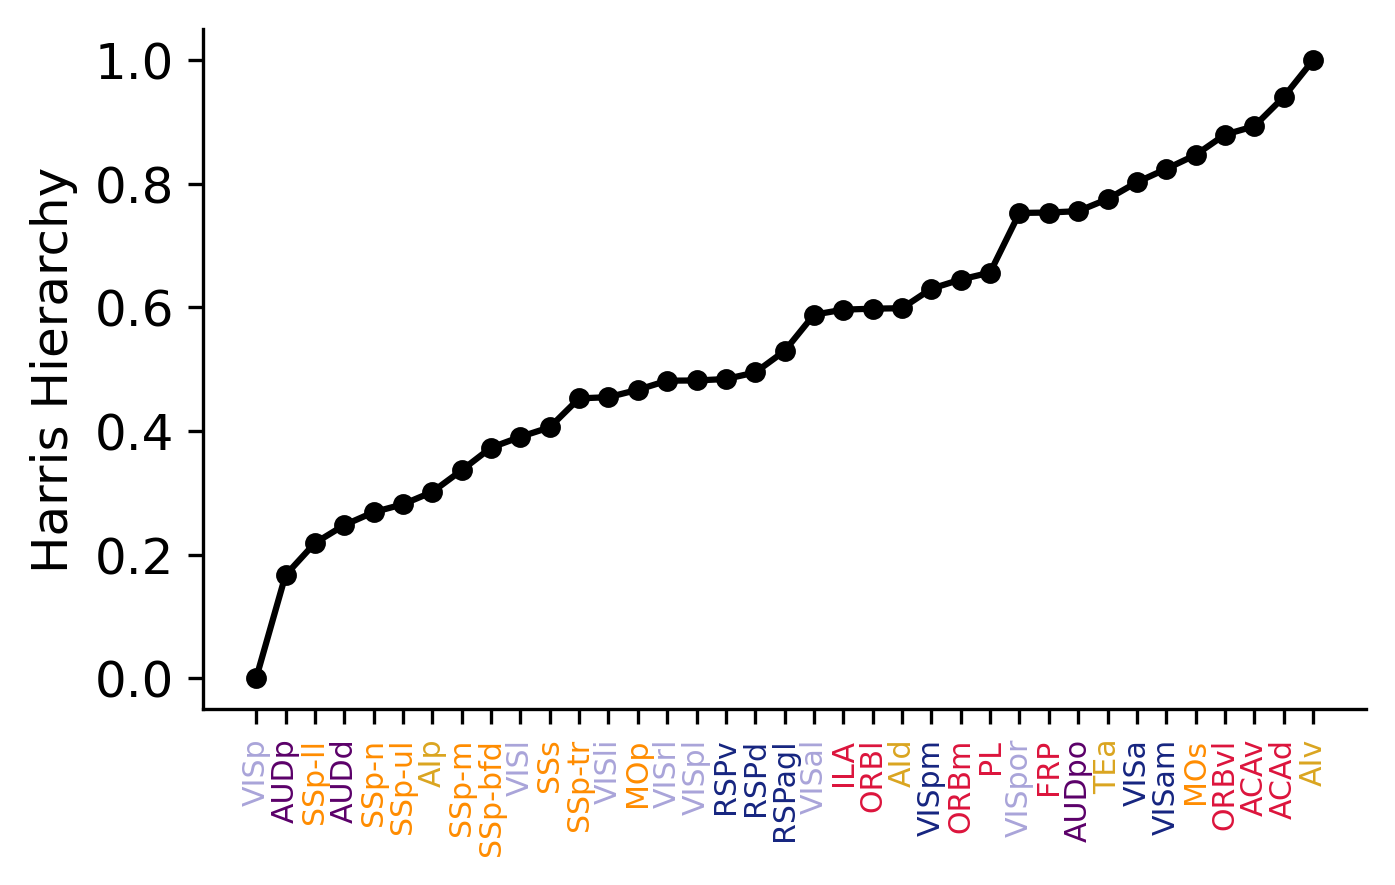

In [14]:
plotHiernotebook(harrisHierarchy_df, 8, r'Harris Hierarchy', (5,3), 12, False, 'loadDataProcessing/harrisHierarchyPlotnotebook.svg')

In [15]:
# download connectivity matrix 
mcc = MouseConnectivityCache(manifest_file='connectivity/mouse_connectivity_manifest.json')
# The manifest file is a simple JSON file that keeps track of all of
# the data that has already been downloaded onto the hard drives.
# If you supply a relative path, it is assumed to be relative to your
# current working directory.

# grab the StructureTree instance
structure_tree = mcc.get_structure_tree()

oapi = OntologiesApi()

# get the ids of all the structure sets in the tree
# structure_set_ids = structure_tree.get_structure_sets()

# download and cache the latest voxel model
# this method returns a tuple with object types:
# (VoxelConnectivityArray, Mask, Mask)
cache = VoxelModelCache(manifest_file='connectivity/voxel_model_manifest.json')

# extracting the cortical subnetwork. get the normalized connectvity density for ipsi side.
normalized_connection_density = cache.get_normalized_connection_density()
full_matrix = normalized_connection_density['ipsi']  # .loc[cortex_ids_int][cortex_ids_str]
mat = np.array(full_matrix)

# cortex
cortex_structures = structure_tree.get_structures_by_set_id([688152357]) # first get the full info of cortex area
# cortex_structures_refined = []
# for s in cortex_structures:
#     if s['id'] in full_matrix.index:
#         cortex_structures_refined.append(s)
cortex_ids_int = [s['id'] for s in cortex_structures]  # get the cortex area id
cortex_ids_str = [str(s['id']) for s in cortex_structures]  
cortex_acr = [s['acronym'] for s in cortex_structures]
cortex_names = [s['name'] for s in cortex_structures]

#thalamus
thal_structures = structure_tree.get_structures_by_set_id([688152363])
thal_structures_refined = [] # some of the thalmic structure not in the cconnectivity matirx
for s in thal_structures:
    if s['id'] in full_matrix.index:
        thal_structures_refined.append(s)

thal_ids_int = [s['id'] for s in thal_structures_refined] # store as a int
thal_ids_str = [str(s['id']) for s in thal_structures_refined] # store as a str
thal_acr = [s['acronym'] for s in thal_structures_refined]
thal_names = [s['name'] for s in thal_structures_refined]


cortical_area_number = np.size(cortex_acr)
print(cortical_area_number)

# W = mat[0:cortical_area_number, 0:cortical_area_number]  # extract the cortical areas

W_ = full_matrix.loc[cortex_ids_int][cortex_ids_str] # this gives the cortico cortical connection
W_cxth_ = full_matrix.loc[cortex_ids_int][thal_ids_str] # this gives cx to thal connecitions shape (43, 40)
W_thcx_ = full_matrix.loc[thal_ids_int][cortex_ids_str] # this gives thal to cx connecitions shape (40, 43)
W = np.array(W_).transpose() # ake a transpose of the W since what the paper used in the transponsed version.
W_cxth = np.array(W_cxth_).transpose()
W_thcx = np.array(W_thcx_).transpose()

43


RT
(39, 43)
(43, 39)
39


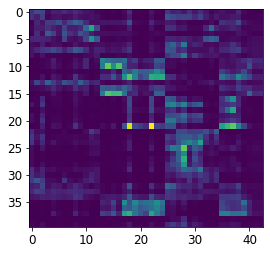

In [16]:
# remove the Reticular Nucleus of the Thalamus
print(thal_acr[34])
thal_acr.remove('RT')
plt.imshow(W_cxth)
W_cxth = np.delete(W_cxth, 34, 0)
print(W_cxth.shape)
W_thcx = np.delete(W_thcx, 34, 1)
print(W_thcx.shape)

# save thalamic arealist
print(len(thal_acr))
np.savetxt("results/thal_list.csv", thal_acr, delimiter=",", fmt = '%s')


array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

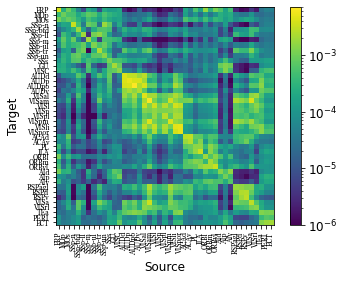

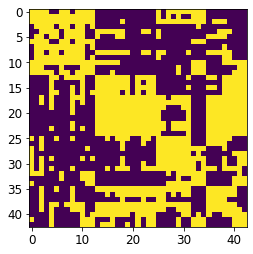

In [17]:
# peek on the connectivity
plot_connectivity(W, cortex_acr,savefig=False)
plt.figure()
plt.imshow(W>1e-4)
W>0 / (len(W)**2 - len(W))

In [18]:
    # areaidxlist = np.arange(len(cortex_acr))
    # # extract the connectivity for list of areas.
    # W_ = W[areaidxlist, :][:, areaidxlist]

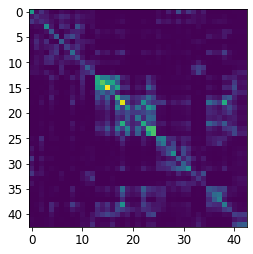

In [19]:
plt.imshow(W)


In [20]:
# generate connectivity matrix 
# this function also sorted the cortical areas in W_cxth and W_thcx.
conn_cxcx,conn_cxth, conn_thcx, area_list_sort, thal_list_sort = generate_connectivity(
    W, cortex_acr, W_cxth, W_thcx, thal_acr ,imgout=False)

(43, 43)
['ACAd', 'ACAv', 'AId', 'AIp', 'AIv', 'AUDd', 'AUDp', 'AUDpo', 'AUDv', 'ECT', 'FRP', 'GU', 'ILA', 'MOp', 'MOs', 'ORBl', 'ORBm', 'ORBvl', 'PERI', 'PL', 'RSPagl', 'RSPd', 'RSPv', 'SSp-bfd', 'SSp-ll', 'SSp-m', 'SSp-n', 'SSp-tr', 'SSp-ul', 'SSp-un', 'SSs', 'TEa', 'VISC', 'VISa', 'VISal', 'VISam', 'VISl', 'VISli', 'VISp', 'VISpl', 'VISpm', 'VISpor', 'VISrl']
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]
[25 26 32 33 34 13 14 15 16 42  0 11 28  1  2 29 30 31 41 27 35 36 37  4
  5  6  3  8  7  9 10 40 12 38 17 18 19 23 20 21 22 24 39]
(39, 43)


In [21]:
print(area_list)
print(thal_acr)

['ACAd', 'ACAv', 'AId', 'AIp', 'AIv', 'AUDd', 'AUDp', 'AUDpo', 'AUDv', 'ECT', 'FRP', 'GU', 'ILA', 'MOp', 'MOs', 'ORBl', 'ORBm', 'ORBvl', 'PERI', 'PL', 'RSPagl', 'RSPd', 'RSPv', 'SSp-bfd', 'SSp-ll', 'SSp-m', 'SSp-n', 'SSp-tr', 'SSp-ul', 'SSp-un', 'SSs', 'TEa', 'VISC', 'VISa', 'VISal', 'VISam', 'VISl', 'VISli', 'VISp', 'VISpl', 'VISpm', 'VISpor', 'VISrl']
['VAL', 'VM', 'VPL', 'VPLpc', 'VPM', 'VPMpc', 'SPFm', 'SPFp', 'SPA', 'PP', 'MG', 'LGd', 'LP', 'PO', 'POL', 'SGN', 'AV', 'AM', 'AD', 'IAM', 'IAD', 'LD', 'IMD', 'MD', 'SMT', 'PR', 'PVT', 'PT', 'RE', 'RH', 'CM', 'PCN', 'CL', 'PF', 'IGL', 'LGv', 'SubG', 'MH', 'LH']


In [22]:
# # quick check which thalamic area project to cortical area  # SSp-n 26  MOs 14 
np.set_printoptions(precision=3, suppress=True)
print(conn_thcx[14, :]*1e5) 

[31.658 36.255 10.501  3.626  6.386 15.386 10.229  0.65  11.852  0.057
  0.225  0.205 11.594 10.522  4.118  0.946 26.618  8.723  9.288  4.911
  7.917  7.975 22.491 17.17  21.233 14.856  3.375  2.68   4.882  9.376
 10.114 20.326 14.063  5.189  0.034  0.068  0.065  0.295  2.551]


In [23]:
# the following are related to cortical-cortical connectivity processing.

In [24]:
# load the volume data and make processing.
dataFile = 'CCFv3SuppTable2.csv'
df = pd.read_csv(dataFile, header=1)
df.head()

,order,structure ID,full structure name,abbreviation,parent_id,depth in tree,structure_id_path,total_voxel_counts (10 um),Structure independently delineated (not merged to form parents),Major Division,"""Summary Structure"" Level for Analyses"
0,0,997,root,root,NaN,0,/997/,506032520,NaN,NaN,NaN
1,1,8,Basic cell groups and regions,grey,997.0,1,/997/8/,449594328,NaN,NaN,NaN
2,2,567,Cerebrum,CH,8.0,2,/997/8/567/,275860156,NaN,NaN,NaN
3,3,688,Cerebral cortex,CTX,567.0,3,/997/8/567/688/,221533548,NaN,NaN,NaN
4,4,695,Cortical plate,CTXpl,688.0,4,/997/8/567/688/695/,212625646,NaN,NaN,NaN


In [25]:
volumeList = []
for area in area_list:
    volume = float(df[df['abbreviation'] == area]['total_voxel_counts (10 um)'])
    volumeList.append(volume)
volume_df = pd.DataFrame([x for x in zip(area_list, volumeList)], columns=['area', 'volume'])
print(volume_df['volume'].max()/volume_df['volume'].min())
volume_df.head()



26.61938766800925


,area,volume
0,ACAd,3131334.0
1,ACAv,2408528.0
2,AId,3724650.0
3,AIp,2434626.0
4,AIv,1734830.0


In [26]:
fig = px.line(volume_df, 'area', 'volume')
fig.show()
# fig.write_image("figure/loadDataProcessing/areaVolume.svg", width=1000, height=350, scale=1)

In [27]:
# load layer 23 cell density
# rawl23density_df = pd.read_csv('results/l23cell_density_iso.csv')
# rawl23density_df.head()

In [28]:
# # generate connectivity that is normalized by volume   and using layer 23 cell density
# areaV3toV2 = {'VISa':'PTLp', 'FRP':'PL', 'VISli':'VISl', 
#         'VISrl':'PTLp', 'VISpor':'VISpl', 'SSp-un': 'SSp-ul'}  # copied from helper.py 
# l23densityList = []
# for area in area_list: 
# #     if curRow.empty: 
#     if area in areaV3toV2: 
#         curRow = rawl23density_df.loc[rawl23density_df['Acronym'] == areaV3toV2[area]] 
#     else:
#         curRow = rawl23density_df.loc[rawl23density_df['Acronym'] == area] 
#     l23densityList.append(float(curRow['Neurons [mm-3]'])) 
# l23density_df = pd.DataFrame([x for x in zip(area_list, l23densityList)], 
#                           columns=['area', 'l23 neuron density'])

# l23density_df.head()

In [29]:
# load cell density  paper: A cell atlas for the mouse brain.
rawdensityMarkram_df = pd.read_csv('results/cell_density_iso_Markram.csv')
rawdensityMarkram_df.head()

,Acronym,Regions,Cells,Neurons,Glia,Excitatory,Inhibitory,Modulatory,Astrocytes,Oligodendrocytes,Microglia
0,FRP,Frontal pole cerebral cortex,75406.15716,46677.91887,28728.23829,9082.52491,37317.769540,277.624418,736.966638,9903.620159,18087.65150
1,MOp,Primary motor area,139973.71160,65189.47578,74784.23582,56924.50748,7669.354996,595.613303,12345.803170,37286.693350,25151.73929
2,MOs,Secondary motor area,143569.82120,65792.20051,77777.62066,53895.13720,11202.789190,694.274116,8852.555741,31674.562060,37250.50286
3,SSp-n,Primary somatosensory area nose,140706.63310,66579.20852,74127.42455,59187.30815,7056.737042,335.163324,7223.614580,31560.274170,35343.53581
4,SSp-bfd,Primary somatosensory area barrel field,172443.05530,81340.09657,91102.95869,74812.41051,6139.549730,388.136331,8885.893712,38191.439360,44025.62562


In [30]:
#generate connectivity that is normalized by volume and norm by cell density
areaV3toV2 = {'VISa':'PTLp', 'FRP':'PL', 'VISli':'VISl', 
        'VISrl':'PTLp', 'VISpor':'VISpl', 'SSp-un': 'SSp-ul'}  # copied from helper.py 
densityMarkramList = []
exdensityMarkramList = []
inhdensityMarkramList = []
for area in area_list: 
#     if curRow.empty: 
    if area in areaV3toV2: 
        curRow = rawdensityMarkram_df.loc[rawdensityMarkram_df['Acronym'] == areaV3toV2[area]] 
    else:
        curRow = rawdensityMarkram_df.loc[rawdensityMarkram_df['Acronym'] == area] 
    densityMarkramList.append(float(curRow['Neurons'])) 
    exdensityMarkramList.append(float(curRow['Excitatory']))
    inhdensityMarkramList.append(float(curRow['Inhibitory']))
densityMarkram_df = pd.DataFrame([x for x in zip(area_list, densityMarkramList, exdensityMarkramList, inhdensityMarkramList)], 
                          columns=['area', 'neuron density', 'excitatory neuron density', 'inhibitory neuron density']) 

densityMarkram_df.head() 

,area,neuron density,excitatory neuron density,inhibitory neuron density
0,ACAd,66059.01898,54585.48501,10733.760190
1,ACAv,87184.88412,67950.71795,18533.718960
2,AId,70218.45077,61439.60622,8324.766385
3,AIp,76680.34983,63774.14520,12536.830050
4,AIv,69508.04572,61498.17703,7554.593054


In [31]:
fig = px.line(densityMarkram_df, 'area', 'neuron density')
fig.show()
# fig.write_image("figure/loadDataProcessing/neuronDensity.svg", width=1000, height=350, scale=1)

densityMarkram_df['ratio'] = densityMarkram_df['excitatory neuron density'] / densityMarkram_df['inhibitory neuron density']
fig = px.line(densityMarkram_df, 'area', ['ratio'])
fig.show()

In [32]:
# seems not used. 
# load cell density
newrawdensity_df = pd.read_csv('results/newrawcell_density_iso.csv')
newrawdensity_df.head()

,Brain region,PV [mm^-3],std PV [mm^-3],SST [mm^-3],std SST [mm^-3],VIP [mm^-3],std VIP [mm^-3],Rest inh. [mm^-3],std Rest inh. [mm^-3],GAD67 [mm^-3],std GAD67 [mm^-3],Non inh. [mm^-3],std Non inh. [mm^-3],Neuron [mm^-3],Volumes [mm^3]
0,Basic cell groups and regions,5973.539694,0.000000,5358.546970,0.000000,1049.199722,0.000000,21529.976910,0.000000,33911.26329,0.000000,21529.976910,0.000000,167290.12520,428.955391
1,Cerebrum,2432.280489,0.000000,5223.492013,0.000000,1607.107740,0.000000,15604.680750,0.000000,24867.56099,0.000000,15604.680750,0.000000,91788.34042,267.984406
2,Cerebral cortex,2858.693804,43.558371,5029.761702,45.642886,1974.603422,31.935781,13385.134010,42.727854,23248.19293,8.644609,13385.134010,8.644609,104507.90590,216.509219
3,Cortical plate,2888.525098,0.000000,4806.314953,0.000000,2013.841285,0.000000,13105.412940,0.000000,22814.09427,0.000000,13105.412940,0.000000,106000.58200,208.074703
4,Isocortex,4167.209868,0.000000,4485.086327,0.000000,2258.434624,0.000000,7030.134426,0.000000,17940.86524,0.000000,7030.134426,0.000000,72779.54043,123.177172


In [33]:
# This is also from paper: A cell atlas for the mouse brain.   
rawdensity_df = pd.read_csv('results/cell_density_iso.csv')  # cell_density_iso.csv is same as cell_density_iso_Markram.csv
rawdensity_df.head()

areaV3toV2 = {'VISa':'PTLp', 'FRP':'PL', 'VISli':'VISl', 
        'VISrl':'PTLp', 'VISpor':'VISpl', 'SSp-un': 'SSp-ul'}  # copied from helper.py 
densityList = []

for area in area_list: 
#     if curRow.empty: 
    if area in areaV3toV2: 
#         print(rawdensity_df[rawdensity_df['Acronym'] == areaV3toV2[area]])
        curRow = rawdensity_df.loc[rawdensity_df['Acronym'] == areaV3toV2[area]]   
#         curRow = rawdensity_df.loc[]
    else:
        curRow = rawdensity_df.loc[rawdensity_df['Acronym'] == area] 
    densityList.append(float(curRow['Neurons'])) 
density_df = pd.DataFrame([x for x in zip(area_list, densityList)], 
                          columns=['area', 'neuron density']) 

density_df.head() 

,area,neuron density
0,ACAd,66059.01898
1,ACAv,87184.88412
2,AId,70218.45077
3,AIp,76680.34983
4,AIv,69508.04572


In [34]:
fig = px.line(density_df, 'area', 'neuron density')
fig.show()


In [35]:
# # plot layer 23 density
# fig = px.line(l23density_df, 'area', 'l23 neuron density')
# fig.show()

In [36]:
# modify the connectivity
# mm11
normDensity = densityList / np.mean(densityList)
densityMat = np.matlib.repmat(normDensity, len(normDensity), 1)

# normVolume = np.array(volume_df['volume'] / volume_df['volume'].mean())
normVolume = volumeList / np.mean(volumeList)
volumeMat = np.matlib.repmat(normVolume, len(normVolume), 1)

# conn_cxcx_densityNorm = conn_cxcx / (densityMat * densityMat.T)
# conn_cxcx_densityNorm = conn_cxcx / densityMat.T   # just for normalize based on target area density.
# conn_cxcx_densityNorm = conn_cxcx * volumeMat / densityMat.T   # normalize based on target area density and by volume
conn_cxcx_norm = conn_cxcx * volumeMat / densityMat.T # scaling based on volume

# conn_cxcx = conn_cxcx_norm

In [37]:
noHierList = [8,9, 11,18,29,32]
print([area_list[i] for i in noHierList])
h = harrisHierarchy[:, 0]
print(h)
hierarchy = []
j = 0
for i in range(n_areas):
    if i in noHierList:
        hierarchy.append(0)
    else:
        hierarchy.append(h[j])
        j += 1
hierarchy = np.array(hierarchy)
print(hierarchy)

['AUDv', 'ECT', 'GU', 'PERI', 'SSp-un', 'VISC']
[0.941 0.893 0.599 0.301 1.    0.248 0.167 0.756 0.754 0.596 0.467 0.847
 0.598 0.645 0.88  0.656 0.53  0.495 0.484 0.373 0.219 0.336 0.269 0.453
 0.281 0.406 0.775 0.803 0.588 0.824 0.391 0.455 0.    0.482 0.63  0.753
 0.481]
[0.941 0.893 0.599 0.301 1.    0.248 0.167 0.756 0.    0.    0.754 0.
 0.596 0.467 0.847 0.598 0.645 0.88  0.    0.656 0.53  0.495 0.484 0.373
 0.219 0.336 0.269 0.453 0.281 0.    0.406 0.775 0.    0.803 0.588 0.824
 0.391 0.455 0.    0.482 0.63  0.753 0.481]


In [38]:
def getPredHi(areaNo, conn, beta):  # not used anymore
    s1, s2 = 0, 0
    for i in range(n_areas):
        if i in noHierList:
            continue
        s1 += np.exp(beta * conn[areaNo, i]) * hierarchy[i]
        s2 += np.exp(beta * conn[areaNo, i])
    s = s1 / s2
#     h = 0.67 * s + 0.15
    h = 0.73 * s + 0.11
    return h

def getPredHi2(areaNo, conn): # the linear relationship is used.
    s1, s2 = 0, 0
    for i in range(n_areas):
        if i in noHierList:
            continue
        s1 += conn[areaNo, i] * hierarchy[i]
        s2 += conn[areaNo, i]
    s = s1 / s2
    h = 1.33 * s - 0.22
    return h

In [39]:
import copy
hierarchyEXP = copy.copy(hierarchy)
for i in noHierList:
    hierarchyEXP[i] = getPredHi(i, conn_cxcx, beta=0.7e4)
    hierarchy[i] = getPredHi2(i, conn_cxcx)
    print(hierarchy[i], area_list[i])
hierarchy_df = pd.DataFrame(hierarchy, index=area_list, columns=['hierarchy index'])
# print(hierarchy_df)

0.39244614549090806 AUDv
0.5659550416684017 ECT
0.5189580332450284 GU
0.533424354684423 PERI
0.35921628520033755 SSp-un
0.43354976497293995 VISC


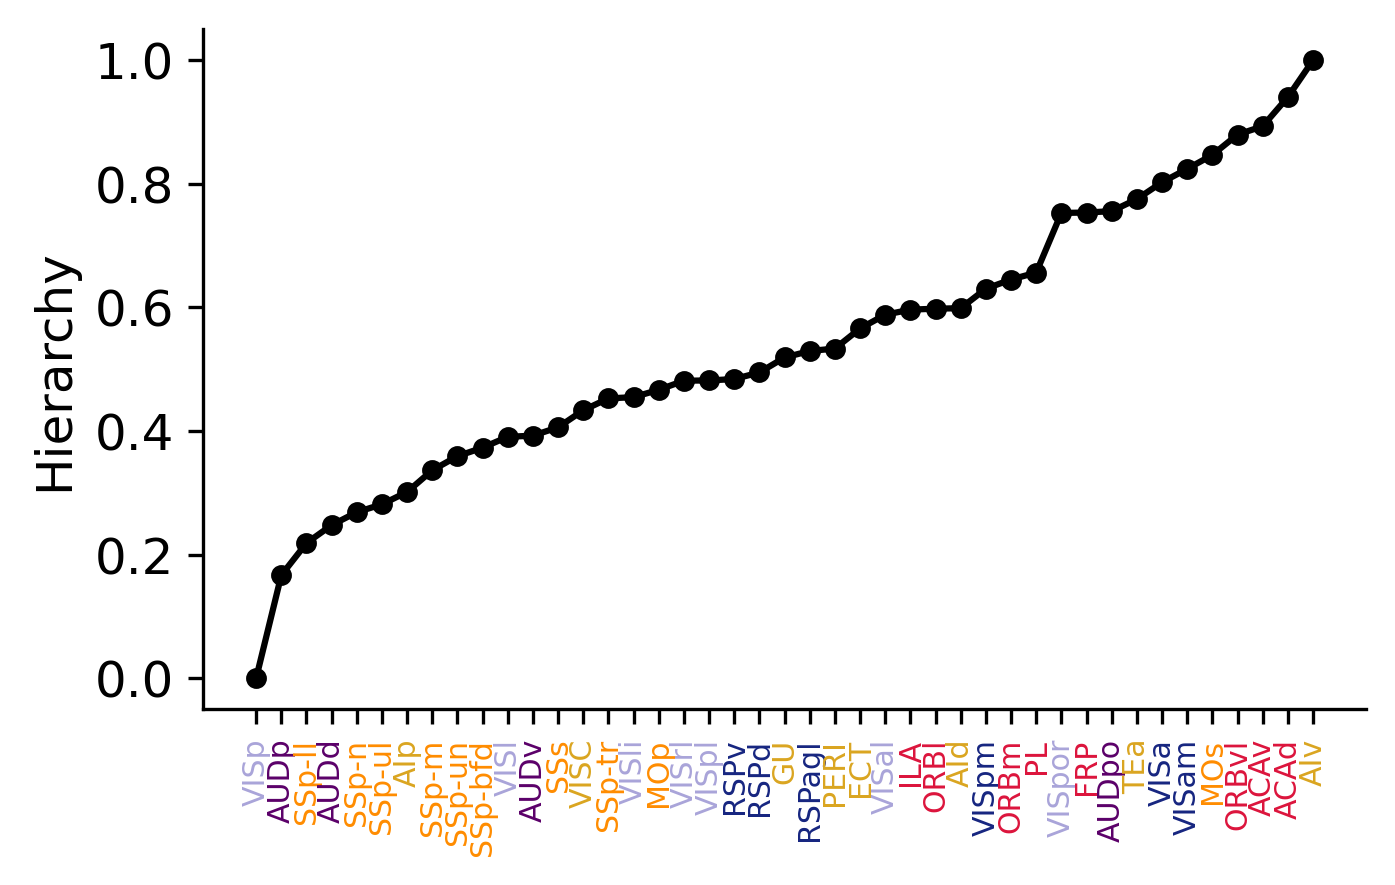

In [40]:
plotHiernotebook(hierarchy_df, 8, r'Hierarchy', (5,3), 12, False, 'loadDataProcessing/hierarchyPlotnotebook.svg')

In [41]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import brian2
import pickle
import networkx as nx
import copy
import seaborn as sns
# from plotFunc import plotPaperTag, getConnHist, getNnodeLoop, plotXYcompr, plotXYcomprCorr, plotXYcomprResidual

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# from adjustText import adjust_text
# import statsmodels.api as sm

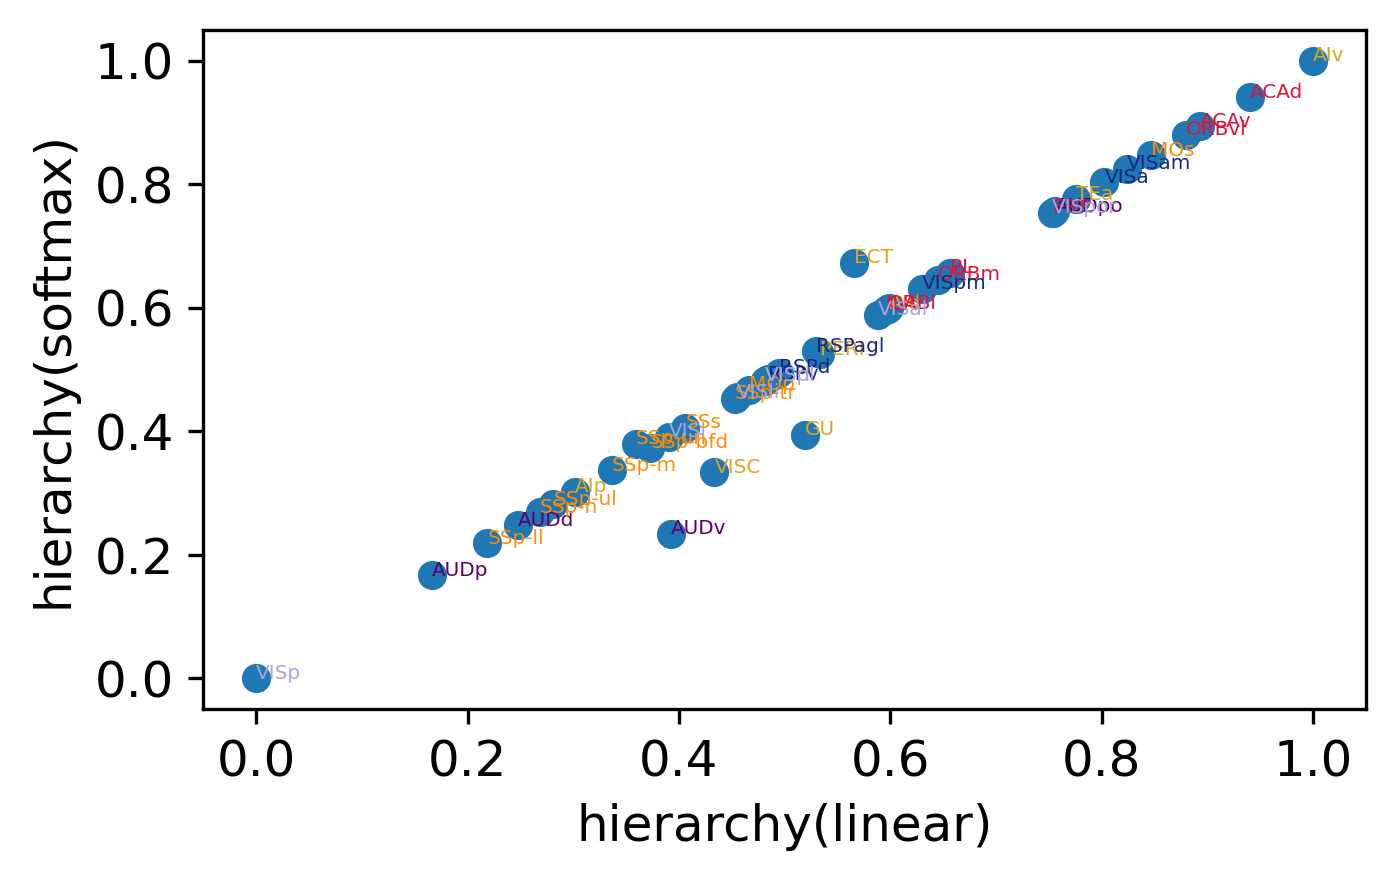

In [42]:
plt.figure(figsize=(5, 3),dpi=300)
plt.scatter(hierarchy, hierarchyEXP)
plt.xlabel('hierarchy(linear)')
plt.ylabel('hierarchy(softmax)')
fontSize = 12
ax = plt.gca()
texts = []
for i in range(len(area_list)):
    acr = area_list[i]
    for div_name, div_color in zip(div_name_list, div_color_list):
        if acr in div[div_name]:
            texts += [ax.text(hierarchy[i], hierarchyEXP[i], acr,
                              color=div_color, fontsize=fontSize*0.4)]

# # use adjust library to adjust the position of annotations.
# if True:
#     adjust_text(texts, hierarchy, hierarchyEXP,
#                 ax=ax, precision=0.001,
#                 arrowprops=dict(arrowstyle='-', color='gray', alpha=.8))

In [43]:
def makeHeatPlotRect(mat, xTicks, yTicks, Xlabel, Ylabel, cbarlabel, colormap, figureSize, fontSize, saveFig, fileName):
    fig = plt.figure(figsize=figureSize, dpi=300, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size': fontSize})
#     plt.imshow(mat, colormap, norm=TwoSlopeNorm(0))
    plt.imshow(mat, colormap)
    cbar = plt.colorbar()
    cbar.set_label(cbarlabel)
    plt.xticks(range(len(xTicks)), xTicks, rotation=90, fontsize=fontSize*0.4)
    plt.yticks(range(len(yTicks)), yTicks, fontsize=fontSize*0.4)
    plt.xlabel(Xlabel)
    plt.ylabel(Ylabel)
    
    # save figure
    if saveFig:
        plt.savefig('figure/' + fileName, dpi=300, bbox_inches='tight', transparent=True)
    # plt.savefig('figure/neurondensity_grad.png',dpi=80,bbox_inc

['VISp', 'AUDp', 'SSp-ll', 'AUDd', 'SSp-n'] 43
[[0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.    0.002 0.   ]
 [0.    0.    0.    ... 0.003 0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]]


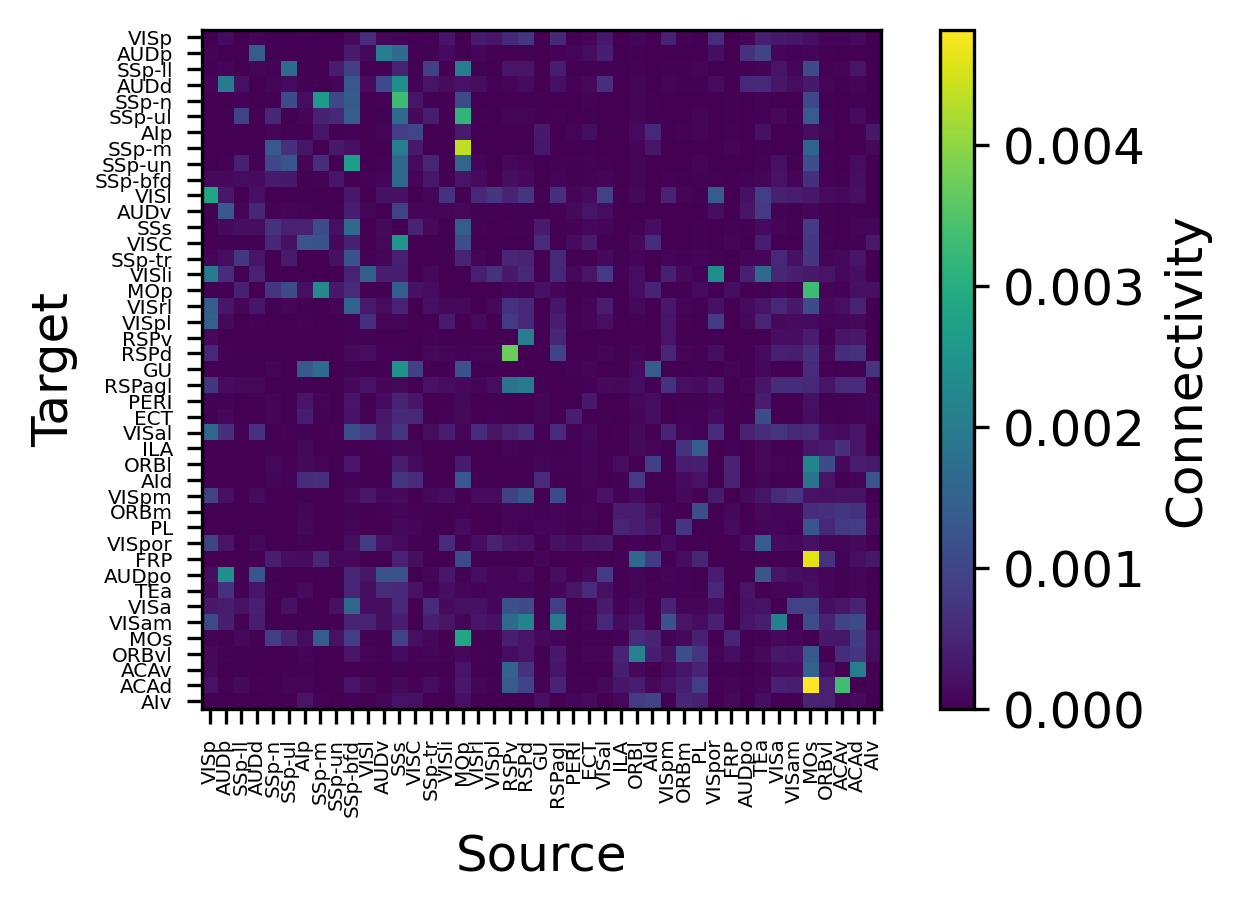

In [44]:
# sortedConn is the cortical connections
# rearrange the connnectivity to be hierarhchical. 
sortedAreaList = [area_list[i] for i in np.argsort(list(hierarchy_df['hierarchy index']))]
print(sortedAreaList[:5], len(sortedAreaList))

sortedConnPre = np.array( [conn_cxcx_norm[:,j].tolist() for j in np.argsort(list(hierarchy_df['hierarchy index']))] )
sortedConn = np.array( [sortedConnPre[:,i].tolist() for i in np.argsort(list(hierarchy_df['hierarchy index']))] )

print(sortedConn)

makeHeatPlotRect(sortedConn, sortedAreaList, sortedAreaList,
                'Source', 'Target', 'Connectivity', 'viridis', (5, 3), 12, False, 'loadDataProcessing/cortexConnectivityMatrix.svg')

[0.000014 0.000009 0.000301 0.00004  0.000125 0.000293 0.000061 0.000429
 0.00031  0.00032  0.000028 0.00001  0.000205 0.000069 0.000434 0.000029
 0.000851 0.000073 0.000005 0.000104 0.000107 0.000159 0.0002   0.000009
 0.000009 0.000109 0.000216 0.000495 0.000216 0.000218 0.000226 0.000375
 0.000012 0.000501 0.000051 0.000012 0.00042  0.000463 0.000789 0.000464
 0.000319 0.000593 0.000132]
[0.000005 0.000008 0.00021  0.000029 0.000071 0.000153 0.000123 0.000124
 0.000184 0.000172 0.000008 0.000014 0.000118 0.00013  0.000308 0.000013
 0.000308 0.000035 0.000002 0.000254 0.000175 0.000171 0.000163 0.000034
 0.000031 0.000052 0.000703 0.000723 0.000305 0.000115 0.000455 0.00068
 0.000008 0.000517 0.000028 0.000023 0.000259 0.000278 0.000664 0.000719
 0.000807 0.000963 0.000264]


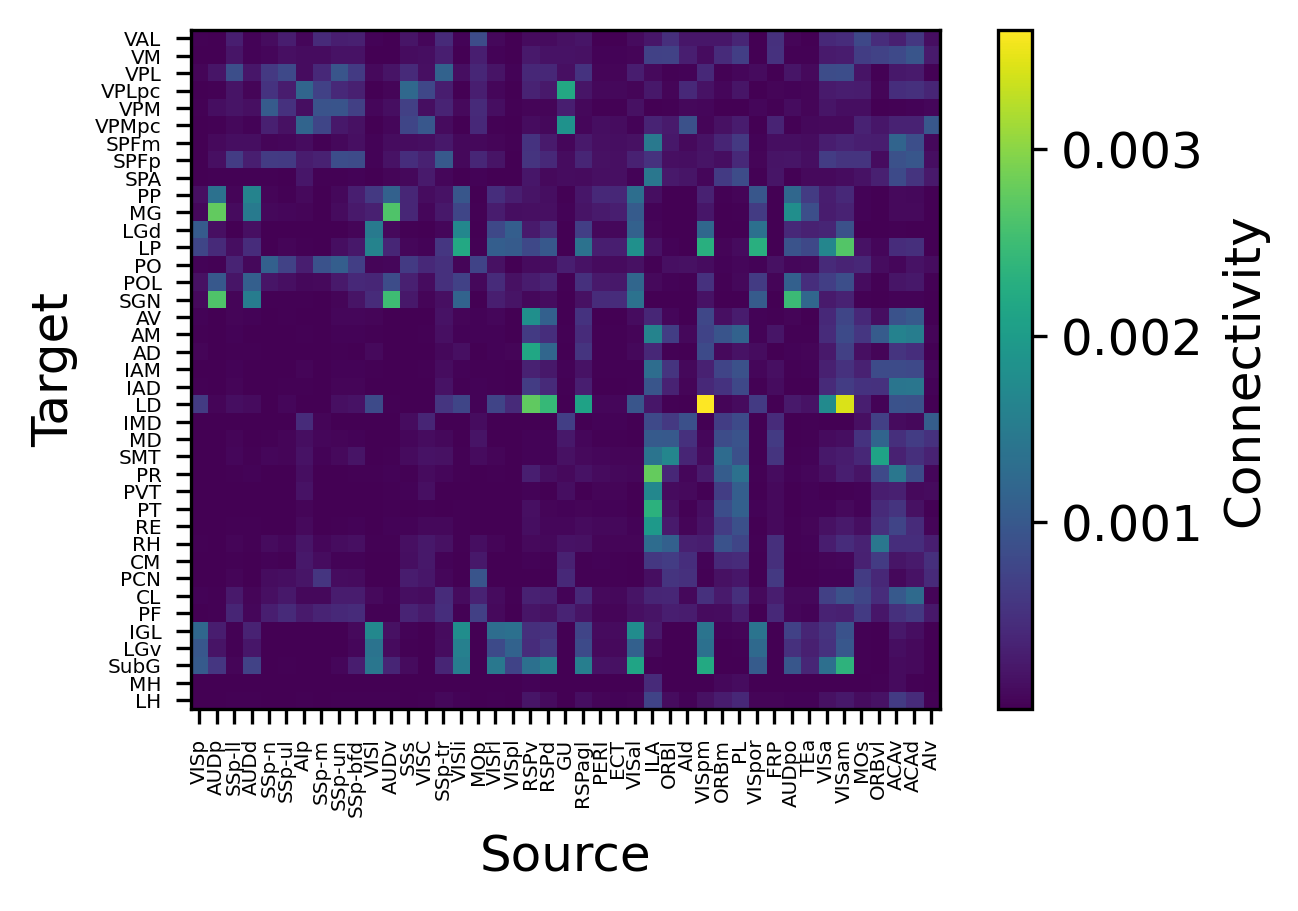

In [45]:

# sortedconncxth is the cortico-thalamic connections

sortedconncxth = np.array( [conn_cxth[:,j].tolist() for j in np.argsort(list(hierarchy_df['hierarchy index']))] ).T

makeHeatPlotRect(sortedconncxth, sortedAreaList, thal_acr,
                'Source', 'Target', 'Connectivity', 'viridis', (5, 3), 12, False, 'loadDataProcessing/cxthConnectivityMatrix.svg')

# the corresponding connectivity submatrix of VM VAL could be extracted as follow
# note that index of VAL is 0, VM is 1.
np.set_printoptions(precision=6) # only show 6 digits
print(sortedconncxth[0,:]) # print out the value of connectivity of VAL
print(sortedconncxth[1,:]) # print out the value of connectivity of VM
# print(sortedconncxth.shape)



[0.000016 0.000002 0.000505 0.000043 0.000072 0.000376 0.000009 0.00022
 0.000301 0.000113 0.000012 0.000003 0.000103 0.000025 0.000381 0.000008
 0.000436 0.000075 0.000015 0.000278 0.000138 0.000078 0.000143 0.000008
 0.000014 0.000038 0.00009  0.000094 0.000103 0.000037 0.000077 0.000203
 0.000008 0.000165 0.000006 0.000007 0.000233 0.000108 0.000317 0.000073
 0.000231 0.000354 0.000045]
[0.000003 0.000002 0.000047 0.000009 0.000062 0.000082 0.000025 0.000202
 0.000056 0.00003  0.000005 0.000003 0.000087 0.000067 0.00002  0.000004
 0.0003   0.000007 0.000008 0.000014 0.00002  0.000151 0.000013 0.000019
 0.000023 0.000007 0.000092 0.000247 0.000335 0.000004 0.000078 0.000222
 0.000009 0.00042  0.000003 0.000011 0.000012 0.000008 0.000363 0.000104
 0.000062 0.000125 0.000098]


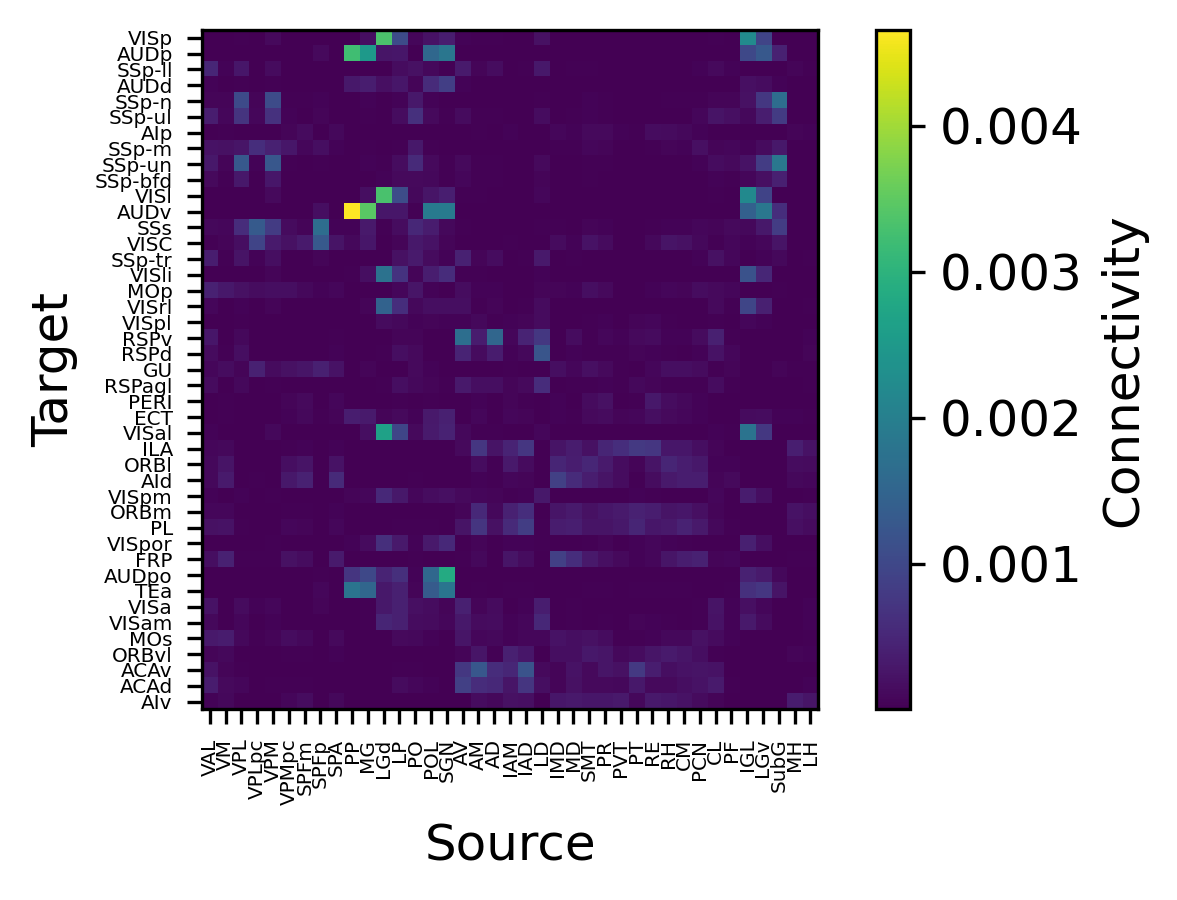

In [46]:
# sortedconnthcx is the thalamo-cortical connecitons
sortedconnthcx = np.array( [conn_thcx[i,:].tolist() for i in np.argsort(list(hierarchy_df['hierarchy index']))] )

makeHeatPlotRect(sortedconnthcx, thal_acr, sortedAreaList,
                'Source', 'Target', 'Connectivity', 'viridis', (5, 3), 12, False, 'loadDataProcessing/thcxConnectivityMatrix.svg')

# the corresponding connectivity submatrix of VM VAL could be extracted as follow
# note that index of VAL is 0, VM is 1.
np.set_printoptions(precision=6) # only show 6 digits
print(sortedconnthcx[:,0]) # print out the value of connectivity of VAL
print(sortedconnthcx[:,1]) # print out the value of connectivity of VM
# print(sortedconnthcx.shape)

In [47]:
# sortedConn is the cortical connections
# sortedconncxth is the cortico-thalamic connections
# sortedconnthcx is the thalamo-cortical connecitons

In [48]:
# # save arealist
# np.savetxt("results/area_list.csv", sortedAreaList, delimiter=",", fmt = '%s')
# # check if loading area list works
# arr = np.loadtxt('results/area_list.csv', delimiter=',', dtype='str')
# arr[0:5]

In [50]:
# # save connectivity
# np.savetxt("results/conn_cxcx.csv", sortedConn, delimiter=",")
# np.savetxt("results/conn_cxth.csv", sortedconncxth, delimiter=",")
# np.savetxt("results/conn_thcx.csv", sortedconnthcx, delimiter=",")

# np.savetxt("results/conn_cxcx_raw.csv", conn_cxcx, delimiter=",")


# volume_df.to_csv('results/dfVolume.csv')
# density_df.to_csv("results/dfDensity.csv")

# # np.savetxt("results/dfDensity.csv", density_df, delimiter=",")